In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fn

import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms

import os
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import VAE

/home/ssawmya/anaconda3/envs/gpu_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib
importlib.reload(VAE)
from VAE import VanillaVAE
from VAE import BaseVAE
from VAE import SaveBestModel


# importlib.reload(SaveBestModel)

In [3]:
# path = 'drive/MyDrive/ACBProj/ProcessedPerturbSeqData/'
# X = load_dataset(path)
path = './average_RPE1_essential_normalized_singlecell_combined.csv'
df = pd.read_csv(path)
# print(df.columns)
df = df.iloc[:,2:]
print(df.shape)

# os.listdir(path)

(8747, 2662)


In [4]:
from torch.utils import data

class RealDataset(data.Dataset):

  def __init__(self, X, y):
    # TODO: Your code here.
    self.features = X
    self.labels = y
    # pass
  
  def __getitem__(self, index):
    # TODO: Your code here.
    x = self.features[index]
    y = self.labels[index]
    return x,y
    # pass

  def __len__(self):
    # TODO: Your code here.
    return len(self.features)
    # pass



In [5]:
import torch
from torch import cuda
from scipy.stats import zscore

X = df.to_numpy()
xt = X.T
# xt = np.log1p(xt)


# xt = X[0].T
os.environ['CUDA_VISIBLE_DEVICES']='1'

if cuda.is_available():
  device = 'cuda'
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

# torch.cuda.set_device("cuda:")
print(torch.cuda.current_device())
A = torch.tensor(xt,device=device)
B = torch.tensor(xt,device = device)
# B = torch.tensor(test_npy, device=device)

trainDataset = RealDataset(A,A)
testDataset = RealDataset(B,B)

batch_size = 256
trainloader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=False)

testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False)
print(device)

0
cuda


In [6]:
x_dim = xt.shape[1]
hidden_dim = 100
print(x_dim,hidden_dim)
vae = VanillaVAE(x_dim,hidden_dim)
vae = vae.to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-4)
save_best_model = SaveBestModel()
model_path = "RPE1_phenotypes_VAE_alt.pth"

8747 100


In [7]:
ginny_pig = xt[0]
print(np.min(ginny_pig),np.max(ginny_pig))

pred,_,_,_ = vae(torch.tensor(ginny_pig,device=device).float())
pred = pred.detach().cpu().numpy()
print(np.min(pred),np.max(pred))

-1.44352222 1.6167507999999997
-0.074733816 0.07700689


In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print("Validation loss didn't increase much from {} for patience {}".format(self.min_validation_loss,self.counter))
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

earlystop = EarlyStopper(patience=30,min_delta=0.001)

In [10]:
num_epochs = 500
train_loss = [0]*num_epochs
test_loss = [0]*num_epochs
print_every = 5
def processLoss(item):
    # print(item)
    item['loss'] = item['loss'].detach().cpu().numpy().tolist()
    item['Reconstruction_Loss'] = item['Reconstruction_Loss'].detach().cpu().numpy().tolist()
    item['KLD'] = item['KLD'].detach().cpu().numpy().tolist()
    return item
for epoch in range(num_epochs):
  pcount = 0
  ncount = 0
  orpcount = 0
  orncount = 0
  vae.train()
  for x, _ in tqdm(trainloader):
    
    optimizer.zero_grad()
   
    # x = x
    x_pred, x_inp, mu, logvar = vae.forward(x.float())
    
    loss_dict = vae.loss_function(x_pred.float(), x_inp.float(), mu.float(), logvar.float())
    
    loss_dict['loss'].backward()
    optimizer.step()
  
  # loss,reco_loss,kld_loss = loss_dict['loss'],loss_dict['Reconstruction_Loss'],loss_dict['kld']
  train_loss[epoch] = processLoss(loss_dict)
  
  
  vae.eval()
  for x,_ in tqdm(testloader):
    x_pred, x_inp, mu, logvar = vae(x.float())
    test_loss_dict = vae.loss_function(x_pred.float(), x_inp.float(), mu.float(), logvar.float())
   
  test_loss[epoch]= processLoss(test_loss_dict)
  # save_best_model(
  #     test_loss_dict['loss'], epoch, vae, optimizer,vae.loss_function,model_path
  # )

  if (epoch+1) % print_every == 0:
      print("[{}] Train Loss={}".format(epoch+1, loss_dict['loss']),"Reconstruction Loss={}".format(loss_dict['Reconstruction_Loss']),"KLD Loss={}".format(loss_dict['KLD']))
      print("[{}] Validation Loss={}".format(epoch+1, test_loss_dict['loss']),"Reconstruction Loss={}".format(test_loss_dict['Reconstruction_Loss']),"KLD Loss={}".format(test_loss_dict['KLD']))
      
  # if(earlystop.early_stop(test_loss[-1]['loss'].detach().cpu().numpy()) == True):
  #   break

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 95.87it/s]


[5] Train Loss=0.09168864786624908 Reconstruction Loss=0.09159938991069794 KLD Loss=-0.0008925775182433426
[5] Validation Loss=0.09109142422676086 Reconstruction Loss=0.09100528806447983 KLD Loss=-0.0008613759418949485


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 420.91it/s]


[10] Train Loss=0.09097283333539963 Reconstruction Loss=0.09091264754533768 KLD Loss=-0.0006018482963554561
[10] Validation Loss=0.09138394892215729 Reconstruction Loss=0.09132561087608337 KLD Loss=-0.0005833992036059499


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 657.46it/s]


[15] Train Loss=0.09167676419019699 Reconstruction Loss=0.0916164368391037 KLD Loss=-0.0006032817182131112
[15] Validation Loss=0.09168357402086258 Reconstruction Loss=0.09163098782300949 KLD Loss=-0.0005258693126961589


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 414.20it/s]


[20] Train Loss=0.09127410501241684 Reconstruction Loss=0.09120810776948929 KLD Loss=-0.00065993593307212
[20] Validation Loss=0.09178481996059418 Reconstruction Loss=0.09172610193490982 KLD Loss=-0.0005871951580047607


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 393.20it/s]


[25] Train Loss=0.09183426201343536 Reconstruction Loss=0.09178481996059418 KLD Loss=-0.000494417326990515
[25] Validation Loss=0.09185031801462173 Reconstruction Loss=0.09180555492639542 KLD Loss=-0.00044766071368940175


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 416.49it/s]


[30] Train Loss=0.09160437434911728 Reconstruction Loss=0.09157182276248932 KLD Loss=-0.0003255079791415483
[30] Validation Loss=0.09145090728998184 Reconstruction Loss=0.09141839295625687 KLD Loss=-0.00032515914062969387


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 413.78it/s]


[35] Train Loss=0.09148532897233963 Reconstruction Loss=0.09145020693540573 KLD Loss=-0.0003512121911626309
[35] Validation Loss=0.09157653898000717 Reconstruction Loss=0.09154155850410461 KLD Loss=-0.0003498184960335493


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 418.79it/s]


[40] Train Loss=0.09214098006486893 Reconstruction Loss=0.09210796654224396 KLD Loss=-0.00033013580832630396
[40] Validation Loss=0.09152282029390335 Reconstruction Loss=0.09148988127708435 KLD Loss=-0.00032937555806711316


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 371.57it/s]


[45] Train Loss=0.09186011552810669 Reconstruction Loss=0.09183068573474884 KLD Loss=-0.00029432657174766064
[45] Validation Loss=0.09188398718833923 Reconstruction Loss=0.09185457974672318 KLD Loss=-0.0002940554404631257


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 651.18it/s]


[50] Train Loss=0.09172900766134262 Reconstruction Loss=0.0916994959115982 KLD Loss=-0.0002951353380922228
[50] Validation Loss=0.0912342220544815 Reconstruction Loss=0.09120597690343857 KLD Loss=-0.0002824731345754117


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 404.49it/s]


[55] Train Loss=0.09116785228252411 Reconstruction Loss=0.09113563597202301 KLD Loss=-0.0003221520164515823
[55] Validation Loss=0.09194329380989075 Reconstruction Loss=0.091911680996418 KLD Loss=-0.0003161132335662842


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 415.30it/s]


[60] Train Loss=0.09146281331777573 Reconstruction Loss=0.09142813086509705 KLD Loss=-0.0003468593058642
[60] Validation Loss=0.091626837849617 Reconstruction Loss=0.09159327298402786 KLD Loss=-0.000335637858370319


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 383.83it/s]


[65] Train Loss=0.09212121367454529 Reconstruction Loss=0.0920834168791771 KLD Loss=-0.0003779413818847388
[65] Validation Loss=0.09175585210323334 Reconstruction Loss=0.09171576052904129 KLD Loss=-0.0004009052354376763


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 423.11it/s]


[70] Train Loss=0.09176041930913925 Reconstruction Loss=0.09172993153333664 KLD Loss=-0.0003049081424251199
[70] Validation Loss=0.09119229018688202 Reconstruction Loss=0.09116192907094955 KLD Loss=-0.0003035767003893852


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 699.43it/s]


[75] Train Loss=0.09177014976739883 Reconstruction Loss=0.09174036234617233 KLD Loss=-0.00029785989318042994
[75] Validation Loss=0.09152835607528687 Reconstruction Loss=0.09149827063083649 KLD Loss=-0.00030084597528912127


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 423.09it/s]


[80] Train Loss=0.0917852595448494 Reconstruction Loss=0.09176064282655716 KLD Loss=-0.00024613915593363345
[80] Validation Loss=0.09166479110717773 Reconstruction Loss=0.09164021909236908 KLD Loss=-0.0002457017544656992


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 699.67it/s]


[85] Train Loss=0.09143278747797012 Reconstruction Loss=0.09140212833881378 KLD Loss=-0.0003065697674173862
[85] Validation Loss=0.09125320613384247 Reconstruction Loss=0.09122351557016373 KLD Loss=-0.00029693631222471595


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 418.16it/s]


[90] Train Loss=0.09160123020410538 Reconstruction Loss=0.09156844019889832 KLD Loss=-0.00032793715945445
[90] Validation Loss=0.09190773218870163 Reconstruction Loss=0.09187527000904083 KLD Loss=-0.0003246124542783946


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 417.49it/s]


[95] Train Loss=0.09196335822343826 Reconstruction Loss=0.09193684160709381 KLD Loss=-0.00026517463265918195
[95] Validation Loss=0.09142656624317169 Reconstruction Loss=0.09140019863843918 KLD Loss=-0.0002636518038343638


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 413.28it/s]


[100] Train Loss=0.09182501584291458 Reconstruction Loss=0.09179382026195526 KLD Loss=-0.00031193916220217943
[100] Validation Loss=0.09092829376459122 Reconstruction Loss=0.09089754521846771 KLD Loss=-0.00030750242876820266


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 396.60it/s]


[105] Train Loss=0.09103831648826599 Reconstruction Loss=0.09100843220949173 KLD Loss=-0.000298832863336429
[105] Validation Loss=0.09155218303203583 Reconstruction Loss=0.09152304381132126 KLD Loss=-0.00029141880804672837


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 584.06it/s]


[110] Train Loss=0.09177086502313614 Reconstruction Loss=0.09174341708421707 KLD Loss=-0.000274502468528226
[110] Validation Loss=0.09166505932807922 Reconstruction Loss=0.0916387066245079 KLD Loss=-0.0002635004639159888


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 419.52it/s]


[115] Train Loss=0.09136281907558441 Reconstruction Loss=0.09133760631084442 KLD Loss=-0.0002520940615795553
[115] Validation Loss=0.09154518693685532 Reconstruction Loss=0.09151977300643921 KLD Loss=-0.0002541489666327834


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 650.26it/s]


[120] Train Loss=0.09141259640455246 Reconstruction Loss=0.0913822278380394 KLD Loss=-0.00030370085733011365
[120] Validation Loss=0.0913141742348671 Reconstruction Loss=0.0912846103310585 KLD Loss=-0.0002956066164188087


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 553.85it/s]


[125] Train Loss=0.09100376814603806 Reconstruction Loss=0.09096752852201462 KLD Loss=-0.00036238806205801666
[125] Validation Loss=0.09198767691850662 Reconstruction Loss=0.09195400774478912 KLD Loss=-0.00033672884455882013


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 417.52it/s]


[130] Train Loss=0.09141355752944946 Reconstruction Loss=0.09138669073581696 KLD Loss=-0.0002686317020561546
[130] Validation Loss=0.09117269515991211 Reconstruction Loss=0.09114671498537064 KLD Loss=-0.00025980468490161


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 421.76it/s]


[135] Train Loss=0.09150336682796478 Reconstruction Loss=0.09147786349058151 KLD Loss=-0.000254997139563784
[135] Validation Loss=0.09114475548267365 Reconstruction Loss=0.09112126380205154 KLD Loss=-0.0002349431160837412


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 416.93it/s]


[140] Train Loss=0.09168533235788345 Reconstruction Loss=0.09165630489587784 KLD Loss=-0.00029027170967310667
[140] Validation Loss=0.09163063764572144 Reconstruction Loss=0.0916021540760994 KLD Loss=-0.00028486462542787194


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 693.55it/s]


[145] Train Loss=0.0916140228509903 Reconstruction Loss=0.09158933907747269 KLD Loss=-0.0002468313032295555
[145] Validation Loss=0.09131310880184174 Reconstruction Loss=0.0912889689207077 KLD Loss=-0.0002413839247310534


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 462.71it/s]


[150] Train Loss=0.09126725792884827 Reconstruction Loss=0.09124083817005157 KLD Loss=-0.00026419322239235044
[150] Validation Loss=0.09158040583133698 Reconstruction Loss=0.09155452251434326 KLD Loss=-0.00025879929307848215


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 420.95it/s]


[155] Train Loss=0.09131023287773132 Reconstruction Loss=0.09128378331661224 KLD Loss=-0.00026447398704476655
[155] Validation Loss=0.09152738004922867 Reconstruction Loss=0.09150108695030212 KLD Loss=-0.0002629248483572155


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 409.33it/s]


[160] Train Loss=0.09158936887979507 Reconstruction Loss=0.09156658500432968 KLD Loss=-0.00022784402244724333
[160] Validation Loss=0.09181377291679382 Reconstruction Loss=0.09179217368364334 KLD Loss=-0.00021596165606752038


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 420.13it/s]


[165] Train Loss=0.0915343314409256 Reconstruction Loss=0.09150233119726181 KLD Loss=-0.0003199887287337333
[165] Validation Loss=0.09207646548748016 Reconstruction Loss=0.09204591810703278 KLD Loss=-0.0003055053821299225


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 383.64it/s]


[170] Train Loss=0.09095586836338043 Reconstruction Loss=0.09093087166547775 KLD Loss=-0.0002499444817658514
[170] Validation Loss=0.09168975055217743 Reconstruction Loss=0.09166522324085236 KLD Loss=-0.00024528568610548973


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 417.17it/s]


[175] Train Loss=0.09135561436414719 Reconstruction Loss=0.09133490920066833 KLD Loss=-0.00020703556947410107
[175] Validation Loss=0.09161624312400818 Reconstruction Loss=0.09159398823976517 KLD Loss=-0.0002225137868663296


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 401.41it/s]


[180] Train Loss=0.09171495586633682 Reconstruction Loss=0.09169143438339233 KLD Loss=-0.00023518649686593562
[180] Validation Loss=0.09113980829715729 Reconstruction Loss=0.091116763651371 KLD Loss=-0.00023046926071401685


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 421.35it/s]


[185] Train Loss=0.0913272500038147 Reconstruction Loss=0.09130329638719559 KLD Loss=-0.0002395206829532981
[185] Validation Loss=0.0920434445142746 Reconstruction Loss=0.0920199453830719 KLD Loss=-0.0002350120630580932


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 430.30it/s]


[190] Train Loss=0.0914861187338829 Reconstruction Loss=0.09146301448345184 KLD Loss=-0.00023100599355529994
[190] Validation Loss=0.09183402359485626 Reconstruction Loss=0.09181105345487595 KLD Loss=-0.00022970901045482606


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 411.62it/s]


[195] Train Loss=0.09127173572778702 Reconstruction Loss=0.0912383645772934 KLD Loss=-0.00033371150493621826
[195] Validation Loss=0.09128599613904953 Reconstruction Loss=0.09125537425279617 KLD Loss=-0.00030623405473306775


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 566.48it/s]


[200] Train Loss=0.09139955043792725 Reconstruction Loss=0.09137839823961258 KLD Loss=-0.0002114854723913595
[200] Validation Loss=0.09123815596103668 Reconstruction Loss=0.09121561050415039 KLD Loss=-0.0002254656865261495


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 513.20it/s]


[205] Train Loss=0.09158842265605927 Reconstruction Loss=0.09156779199838638 KLD Loss=-0.00020629109349101782
[205] Validation Loss=0.091385118663311 Reconstruction Loss=0.09136509895324707 KLD Loss=-0.00020019944349769503


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 420.39it/s]


[210] Train Loss=0.09143862128257751 Reconstruction Loss=0.09142099320888519 KLD Loss=-0.0001762766478350386
[210] Validation Loss=0.09113894402980804 Reconstruction Loss=0.09112177044153214 KLD Loss=-0.0001717142731649801


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 419.14it/s]


[215] Train Loss=0.09153605252504349 Reconstruction Loss=0.09150851517915726 KLD Loss=-0.0002753717126324773
[215] Validation Loss=0.09180886298418045 Reconstruction Loss=0.09178059548139572 KLD Loss=-0.0002826890558935702


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 401.66it/s]


[220] Train Loss=0.09152746945619583 Reconstruction Loss=0.09150216728448868 KLD Loss=-0.00025302727590315044
[220] Validation Loss=0.09215855598449707 Reconstruction Loss=0.0921330600976944 KLD Loss=-0.0002549877972342074


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 415.16it/s]


[225] Train Loss=0.09131880104541779 Reconstruction Loss=0.09129930287599564 KLD Loss=-0.00019500157213769853
[225] Validation Loss=0.09090849757194519 Reconstruction Loss=0.09088820964097977 KLD Loss=-0.0002029114548349753


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 707.19it/s]


[230] Train Loss=0.09121675044298172 Reconstruction Loss=0.09118900448083878 KLD Loss=-0.0002774613967631012
[230] Validation Loss=0.09124619513750076 Reconstruction Loss=0.09122012555599213 KLD Loss=-0.0002606800408102572


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 95.57it/s]


[235] Train Loss=0.09148303419351578 Reconstruction Loss=0.09145250916481018 KLD Loss=-0.0003052251704502851
[235] Validation Loss=0.09152355790138245 Reconstruction Loss=0.0914912074804306 KLD Loss=-0.0003235229232814163


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 413.18it/s]


[240] Train Loss=0.09137824922800064 Reconstruction Loss=0.09135254472494125 KLD Loss=-0.00025707395980134606
[240] Validation Loss=0.0910959392786026 Reconstruction Loss=0.09107016026973724 KLD Loss=-0.000257781328400597


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 414.51it/s]


[245] Train Loss=0.09131300449371338 Reconstruction Loss=0.0912928357720375 KLD Loss=-0.00020169744675513357
[245] Validation Loss=0.09108790010213852 Reconstruction Loss=0.09106780588626862 KLD Loss=-0.0002009734307648614


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 652.40it/s]


[250] Train Loss=0.09146690368652344 Reconstruction Loss=0.09144439548254013 KLD Loss=-0.00022507064568344504
[250] Validation Loss=0.09177324175834656 Reconstruction Loss=0.09175176173448563 KLD Loss=-0.00021479323913808912


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 399.37it/s]


[255] Train Loss=0.09133612364530563 Reconstruction Loss=0.09131378680467606 KLD Loss=-0.00022340552823152393
[255] Validation Loss=0.0913342759013176 Reconstruction Loss=0.09131305664777756 KLD Loss=-0.00021221562928985804


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 513.58it/s]


[260] Train Loss=0.09133296459913254 Reconstruction Loss=0.0913146585226059 KLD Loss=-0.0001830441178753972
[260] Validation Loss=0.09175465255975723 Reconstruction Loss=0.09173692762851715 KLD Loss=-0.0001772539981175214


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 578.71it/s]


[265] Train Loss=0.09114895761013031 Reconstruction Loss=0.09112071990966797 KLD Loss=-0.00028240069514140487
[265] Validation Loss=0.09122300148010254 Reconstruction Loss=0.09119412302970886 KLD Loss=-0.0002887856971938163


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 440.60it/s]


[270] Train Loss=0.09162494540214539 Reconstruction Loss=0.0916035994887352 KLD Loss=-0.00021344804554246366
[270] Validation Loss=0.09128157049417496 Reconstruction Loss=0.09125953167676926 KLD Loss=-0.00022041301417630166


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 697.75it/s]


[275] Train Loss=0.0915573462843895 Reconstruction Loss=0.09153291583061218 KLD Loss=-0.00024433317594230175
[275] Validation Loss=0.09136690944433212 Reconstruction Loss=0.09134230017662048 KLD Loss=-0.00024607370141893625


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 698.83it/s]


[280] Train Loss=0.09165284037590027 Reconstruction Loss=0.09162963926792145 KLD Loss=-0.0002320046623935923
[280] Validation Loss=0.09166295826435089 Reconstruction Loss=0.09163779765367508 KLD Loss=-0.0002516379754524678


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 692.07it/s]


[285] Train Loss=0.09167487174272537 Reconstruction Loss=0.0916510820388794 KLD Loss=-0.00023788915132172406
[285] Validation Loss=0.09153755754232407 Reconstruction Loss=0.09151402115821838 KLD Loss=-0.00023535246145911515


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 407.83it/s]


[290] Train Loss=0.09117578715085983 Reconstruction Loss=0.09116003662347794 KLD Loss=-0.000157500893692486
[290] Validation Loss=0.0913165956735611 Reconstruction Loss=0.09129971265792847 KLD Loss=-0.00016879655595403165


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 420.13it/s]


[295] Train Loss=0.09153428673744202 Reconstruction Loss=0.09151112288236618 KLD Loss=-0.00023164147569332272
[295] Validation Loss=0.09173054248094559 Reconstruction Loss=0.0917067751288414 KLD Loss=-0.00023764373327139765


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 413.44it/s]


[300] Train Loss=0.09192024916410446 Reconstruction Loss=0.09189774841070175 KLD Loss=-0.00022503529908135533
[300] Validation Loss=0.09169166535139084 Reconstruction Loss=0.0916680246591568 KLD Loss=-0.0002364209503866732


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 693.69it/s]


[305] Train Loss=0.09108223021030426 Reconstruction Loss=0.09106364846229553 KLD Loss=-0.00018580054165795445
[305] Validation Loss=0.09159674495458603 Reconstruction Loss=0.09157797694206238 KLD Loss=-0.00018770496535580605


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 390.14it/s]


[310] Train Loss=0.09124579280614853 Reconstruction Loss=0.09122639894485474 KLD Loss=-0.00019396492280066013
[310] Validation Loss=0.09120918810367584 Reconstruction Loss=0.09118881076574326 KLD Loss=-0.00020378331828396767


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 421.05it/s]


[315] Train Loss=0.09078755229711533 Reconstruction Loss=0.0907706767320633 KLD Loss=-0.00016873228014446795
[315] Validation Loss=0.0913359671831131 Reconstruction Loss=0.09131817519664764 KLD Loss=-0.000177900874405168


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 656.45it/s]


[320] Train Loss=0.09133914858102798 Reconstruction Loss=0.09131105244159698 KLD Loss=-0.0002809257712215185
[320] Validation Loss=0.09132330119609833 Reconstruction Loss=0.09129471331834793 KLD Loss=-0.00028590127476491034


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 417.10it/s]


[325] Train Loss=0.09131461381912231 Reconstruction Loss=0.09129000455141068 KLD Loss=-0.000246057054027915
[325] Validation Loss=0.09123630821704865 Reconstruction Loss=0.09121263027191162 KLD Loss=-0.00023679611331317574


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 717.22it/s]


[330] Train Loss=0.09128478914499283 Reconstruction Loss=0.09126272797584534 KLD Loss=-0.00022063740470912308
[330] Validation Loss=0.0911749079823494 Reconstruction Loss=0.0911511778831482 KLD Loss=-0.0002373176539549604


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 694.19it/s]


[335] Train Loss=0.09144824743270874 Reconstruction Loss=0.09142743051052094 KLD Loss=-0.00020819815108552575
[335] Validation Loss=0.09122485667467117 Reconstruction Loss=0.09120532125234604 KLD Loss=-0.00019536825129762292


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 546.99it/s]


[340] Train Loss=0.09145497530698776 Reconstruction Loss=0.09143482893705368 KLD Loss=-0.0002014908823184669
[340] Validation Loss=0.09138569980859756 Reconstruction Loss=0.09136588871479034 KLD Loss=-0.00019811357196886092


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 701.95it/s]


[345] Train Loss=0.09103842824697495 Reconstruction Loss=0.09101853519678116 KLD Loss=-0.00019893664284609258
[345] Validation Loss=0.09137825667858124 Reconstruction Loss=0.09135804325342178 KLD Loss=-0.00020210504590068012


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 480.81it/s]


[350] Train Loss=0.09127514064311981 Reconstruction Loss=0.09125678241252899 KLD Loss=-0.00018359633395448327
[350] Validation Loss=0.09125132858753204 Reconstruction Loss=0.09123221784830093 KLD Loss=-0.00019110886205453426


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 500.04it/s]


[355] Train Loss=0.09144579619169235 Reconstruction Loss=0.09143047779798508 KLD Loss=-0.00015317050565499812
[355] Validation Loss=0.0911732092499733 Reconstruction Loss=0.09115881472826004 KLD Loss=-0.00014393879973795265


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 406.30it/s]


[360] Train Loss=0.09128770232200623 Reconstruction Loss=0.09126981347799301 KLD Loss=-0.00017888435104396194
[360] Validation Loss=0.09140070527791977 Reconstruction Loss=0.09138359874486923 KLD Loss=-0.0001710367068881169


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 410.49it/s]


[365] Train Loss=0.09113303571939468 Reconstruction Loss=0.09111297875642776 KLD Loss=-0.00020056379435118288
[365] Validation Loss=0.09143118560314178 Reconstruction Loss=0.09141188859939575 KLD Loss=-0.00019296741811558604


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 416.15it/s]


[370] Train Loss=0.09109842777252197 Reconstruction Loss=0.09107398241758347 KLD Loss=-0.00024447691976092756
[370] Validation Loss=0.09152965247631073 Reconstruction Loss=0.09150326251983643 KLD Loss=-0.00026390922721475363


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 679.54it/s]


[375] Train Loss=0.09109722822904587 Reconstruction Loss=0.0910765752196312 KLD Loss=-0.00020650117949116975
[375] Validation Loss=0.09121100604534149 Reconstruction Loss=0.09118977189064026 KLD Loss=-0.00021237194596324116


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 680.17it/s]


[380] Train Loss=0.09151861816644669 Reconstruction Loss=0.0915030688047409 KLD Loss=-0.00015547288057859987
[380] Validation Loss=0.09149961918592453 Reconstruction Loss=0.09148411452770233 KLD Loss=-0.00015507142234127969


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 703.59it/s]


[385] Train Loss=0.0913524404168129 Reconstruction Loss=0.09133375436067581 KLD Loss=-0.00018684976384975016
[385] Validation Loss=0.09132975339889526 Reconstruction Loss=0.0913115069270134 KLD Loss=-0.0001824883947847411


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 704.87it/s]


[390] Train Loss=0.09161376953125 Reconstruction Loss=0.09159750491380692 KLD Loss=-0.00016266107559204102
[390] Validation Loss=0.09134373068809509 Reconstruction Loss=0.0913289338350296 KLD Loss=-0.00014798284973949194


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 412.05it/s]


[395] Train Loss=0.09144263714551926 Reconstruction Loss=0.09142220765352249 KLD Loss=-0.00020431421580724418
[395] Validation Loss=0.09166432172060013 Reconstruction Loss=0.09164530783891678 KLD Loss=-0.0001901686191558838


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 673.66it/s]


[400] Train Loss=0.09144066274166107 Reconstruction Loss=0.09142280369997025 KLD Loss=-0.00017858661885838956
[400] Validation Loss=0.0912184938788414 Reconstruction Loss=0.09120047092437744 KLD Loss=-0.0001802555489121005


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 428.65it/s]


[405] Train Loss=0.09127061814069748 Reconstruction Loss=0.09125033766031265 KLD Loss=-0.0002027896116487682
[405] Validation Loss=0.09129039943218231 Reconstruction Loss=0.091270811855793 KLD Loss=-0.00019585210247896612


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 394.86it/s]


[410] Train Loss=0.09105297178030014 Reconstruction Loss=0.09103086590766907 KLD Loss=-0.00022105814423412085
[410] Validation Loss=0.09118342399597168 Reconstruction Loss=0.09115925431251526 KLD Loss=-0.00024166879302356392


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 678.55it/s]


[415] Train Loss=0.09123823046684265 Reconstruction Loss=0.09122250974178314 KLD Loss=-0.00015723005344625562
[415] Validation Loss=0.09125318378210068 Reconstruction Loss=0.09123703837394714 KLD Loss=-0.00016142487584147602


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 611.74it/s]


[420] Train Loss=0.09107119590044022 Reconstruction Loss=0.09105576574802399 KLD Loss=-0.0001543167163617909
[420] Validation Loss=0.09133147448301315 Reconstruction Loss=0.09131668508052826 KLD Loss=-0.00014785838720854372


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 685.53it/s]


[425] Train Loss=0.091423898935318 Reconstruction Loss=0.09140520542860031 KLD Loss=-0.00018696019833441824
[425] Validation Loss=0.09126026928424835 Reconstruction Loss=0.09124114364385605 KLD Loss=-0.00019124735263176262


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 430.75it/s]


[430] Train Loss=0.09098215401172638 Reconstruction Loss=0.09096383303403854 KLD Loss=-0.000183182317414321
[430] Validation Loss=0.09175310283899307 Reconstruction Loss=0.09173504263162613 KLD Loss=-0.00018060646834783256


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 391.91it/s]


[435] Train Loss=0.09120094776153564 Reconstruction Loss=0.09118194133043289 KLD Loss=-0.00019004649948328733
[435] Validation Loss=0.0915365219116211 Reconstruction Loss=0.09151706099510193 KLD Loss=-0.00019460654584690928


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 501.84it/s]


[440] Train Loss=0.09131090342998505 Reconstruction Loss=0.09129112213850021 KLD Loss=-0.00019783132302109152
[440] Validation Loss=0.09151909500360489 Reconstruction Loss=0.09149851649999619 KLD Loss=-0.00020580695127137005


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 687.19it/s]


[445] Train Loss=0.09126013517379761 Reconstruction Loss=0.09124168753623962 KLD Loss=-0.0001844667422119528
[445] Validation Loss=0.09113231301307678 Reconstruction Loss=0.09111352264881134 KLD Loss=-0.00018793257186189294


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 725.41it/s]


[450] Train Loss=0.09136193990707397 Reconstruction Loss=0.09134000539779663 KLD Loss=-0.00021933137031737715
[450] Validation Loss=0.09144513309001923 Reconstruction Loss=0.09142319858074188 KLD Loss=-0.00021934100368525833


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 391.58it/s]


[455] Train Loss=0.09103183448314667 Reconstruction Loss=0.09101602435112 KLD Loss=-0.00015807240561116487
[455] Validation Loss=0.09114979952573776 Reconstruction Loss=0.09113334864377975 KLD Loss=-0.00016452693671453744


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 422.75it/s]


[460] Train Loss=0.09154892712831497 Reconstruction Loss=0.09153251349925995 KLD Loss=-0.00016412782133556902
[460] Validation Loss=0.09111402928829193 Reconstruction Loss=0.09109755605459213 KLD Loss=-0.000164736426086165


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 416.24it/s]


[465] Train Loss=0.09131874144077301 Reconstruction Loss=0.09129904955625534 KLD Loss=-0.00019688349857460707
[465] Validation Loss=0.09135394543409348 Reconstruction Loss=0.09133630990982056 KLD Loss=-0.00017633714014664292


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 371.95it/s]


[470] Train Loss=0.0913836881518364 Reconstruction Loss=0.09136713296175003 KLD Loss=-0.00016558491915930063
[470] Validation Loss=0.09128224849700928 Reconstruction Loss=0.09126388281583786 KLD Loss=-0.0001836267183534801


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 401.22it/s]


[475] Train Loss=0.09120786935091019 Reconstruction Loss=0.0911855548620224 KLD Loss=-0.00022313992667477578
[475] Validation Loss=0.0917169526219368 Reconstruction Loss=0.09169460833072662 KLD Loss=-0.0002234104904346168


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 665.35it/s]


[480] Train Loss=0.09135307371616364 Reconstruction Loss=0.09133625775575638 KLD Loss=-0.00016814119589980692
[480] Validation Loss=0.09137701243162155 Reconstruction Loss=0.09135925024747849 KLD Loss=-0.00017764346557669342


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 719.21it/s]


[485] Train Loss=0.09151581674814224 Reconstruction Loss=0.09149909764528275 KLD Loss=-0.00016721294377930462
[485] Validation Loss=0.09140199422836304 Reconstruction Loss=0.0913843959569931 KLD Loss=-0.00017598331032786518


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 541.67it/s]


[490] Train Loss=0.09146371483802795 Reconstruction Loss=0.09144741296768188 KLD Loss=-0.00016299942217301577
[490] Validation Loss=0.09123583137989044 Reconstruction Loss=0.09121809899806976 KLD Loss=-0.00017729723185766488


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 423.71it/s]


[495] Train Loss=0.09129007160663605 Reconstruction Loss=0.09127306193113327 KLD Loss=-0.0001701277360552922
[495] Validation Loss=0.09139546006917953 Reconstruction Loss=0.09138056635856628 KLD Loss=-0.0001489517162553966


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 697.00it/s]


[500] Train Loss=0.09130372107028961 Reconstruction Loss=0.09128884971141815 KLD Loss=-0.00014869606820866466
[500] Validation Loss=0.09108428657054901 Reconstruction Loss=0.09106998890638351 KLD Loss=-0.00014299563190434128


In [8]:
def processLoss(item):
    item['loss'] = item['loss'].detach().cpu().numpy().tolist()
    item['Reconstruction_Loss'] = item['Reconstruction_Loss'].detach().cpu().numpy().tolist()
    item['KLD'] = item['KLD'].detach().cpu().numpy().tolist()
    return item

count = 0
for train,test in zip(train_loss,test_loss):
    
    # print(count,train,test)
    train_loss[count] = processLoss(train)
    test_loss[count] = processLoss(test)
    count +=1

# print(train_loss,test_loss)
import json
with open('trainLossRPE1', 'w') as fout:
    json.dump(train_loss, fout)
    
with open('testLossRPE1', 'w') as fout:
    json.dump(test_loss, fout)

In [18]:
with open('trainLossRPE1', 'r') as fout:
    train_dict = json.loads(fout.read())

print(train_dict)

[{'loss': 0.09704228490591049, 'Reconstruction_Loss': 0.09343945980072021, 'KLD': -0.003602827899158001}, {'loss': 0.09314844757318497, 'Reconstruction_Loss': 0.09186723083257675, 'KLD': -0.0012812159257009625}, {'loss': 0.0929105207324028, 'Reconstruction_Loss': 0.09224295616149902, 'KLD': -0.0006675670738331974}, {'loss': 0.09247349202632904, 'Reconstruction_Loss': 0.0920361801981926, 'KLD': -0.00043731139157898724}, {'loss': 0.09318248182535172, 'Reconstruction_Loss': 0.09287572652101517, 'KLD': -0.00030675853486172855}, {'loss': 0.09425710141658783, 'Reconstruction_Loss': 0.09400300681591034, 'KLD': -0.0002540948917157948}, {'loss': 0.0957818478345871, 'Reconstruction_Loss': 0.09534451365470886, 'KLD': -0.0004373338888399303}, {'loss': 0.09435126930475235, 'Reconstruction_Loss': 0.09379440546035767, 'KLD': -0.0005568605265580118}, {'loss': 0.09450146555900574, 'Reconstruction_Loss': 0.0939708799123764, 'KLD': -0.0005305844824761152}, {'loss': 0.09332753717899323, 'Reconstruction_Lo

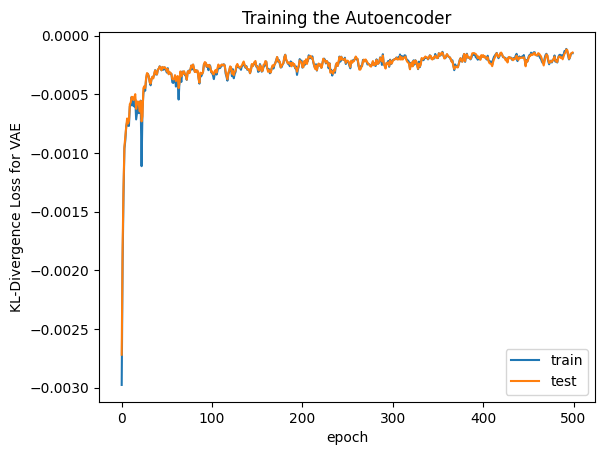

In [17]:
import matplotlib.pyplot as plt

# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(range(num_epochs),[tl['KLD'] for tl in train_loss])
plt.plot(range(num_epochs),[tl['KLD'] for tl in test_loss])
plt.title('Training the Autoencoder')
plt.ylabel('KL-Divergence Loss for VAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig("K562_KLD_loss.jpg",bbox_inches='tight')
plt.show()


In [18]:
model = vae
path = 'rpe1.pth'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss[epoch],
    }, path)

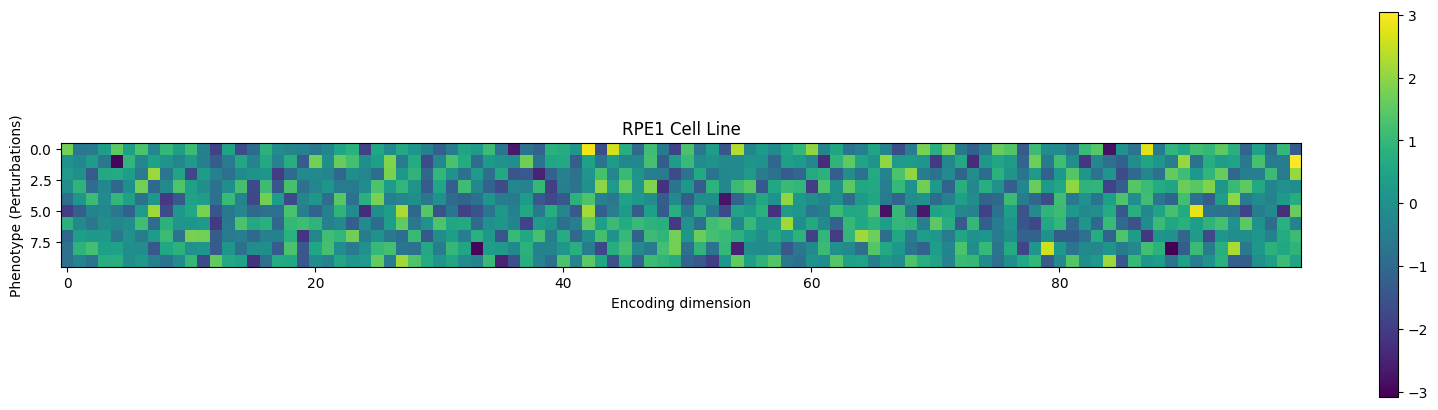

In [55]:
# decoded_mats, x_inp, mu, logvar = vae(torch.tensor(xt,device=device).float())

# z_vec = vae.reparameterize(mu,logvar)

from matplotlib.pyplot import figure


#plt.figure(figsize=(6, 6))
figure(figsize=(20,5))
plt.title('RPE1 Cell Line')
plt.ylabel('Phenotype (Perturbations)')
plt.xlabel('Encoding dimension')
plt.imshow(z_vec.detach().cpu().numpy()[0:10])
plt.colorbar()
plt.savefig("RPE1_100_VAE_latent_combined_data.jpg")


# Inference

In [ ]:
import torch
from torch import cuda

if cuda.is_available():
  device = 'cuda'
else:
  print('WARNING: you are running on a cpu!')
  device = 'cpu'

xt = X[0].T
print(xt.shape)
A = torch.tensor(xt,device=device)
# trainDataset = RealDataset(A,A)

batch_size = 16
# trainloader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

# model_path = "drive/MyDrive/ACBProj/VAE_Models/real_dataset_new_hiddSize_10.pth"

x_dim = xt.shape[1]
# hidden_dim = 10
vae = VanillaVAE(x_dim,hidden_dim).cuda()
vae_inf = VanillaVAE(x_dim,hidden_dim)
vae_inf.load_state_dict(torch.load(model_path)['model_state_dict'])

vae_inf = vae_inf.to(device)

(2273, 8563)


In [19]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA 
import seaborn as sns
import math
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

vae_inf = vae

@torch.no_grad()
def inference(A):
  A = A.to(device)
  # vae_inf = vae_inf.to(device)
  x_pred, x, mu, logvar = vae_inf(A.float())
  std = torch.exp(0.5 * logvar)
  epilson = torch.rand_like(std)
  z_vec = std * epilson + mu
  # print(mu.shape)
  return z_vec,mu


z_vec,mu = inference(A)
# print(mean.shape)
z_vec = z_vec.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()

# TSNE


In [50]:
from sklearn.manifold import TSNE
mean = mu.detach().cpu().numpy()
tsne = TSNE(verbose=1,n_iter=1000, perplexity=4.0)
res = tsne.fit_transform(mean)

/home/ssawmya/anaconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ssawmya/anaconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 2662 samples in 0.000s...
[t-SNE] Computed neighbors for 2662 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2662
[t-SNE] Computed conditional probabilities for sample 2000 / 2662
[t-SNE] Computed conditional probabilities for sample 2662 / 2662
[t-SNE] Mean sigma: 0.000432
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.517708
[t-SNE] KL divergence after 1000 iterations: 1.358668


In [70]:
def plot_clusters(df,labels):
  #Getting unique labels
  # print(df.shape)
  df['labels'] = labels 
  u_labels = np.unique(labels)
  
  #plotting the results:
  
  for i in u_labels:
      plt.scatter(df.values[labels == i , 0] , df.values[labels == i , 1])
  # plt.legend()
  plt.title("RPE1 Cell Latent Space (TSNE)")
  plt.show()

In [ ]:
# TSNE No Clustering
plt.scatter(res[:,0],res[:,1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("RPE1 Cell Data")
plt.savefig("RPE1_TSNE_Whole_VAE",bbox_inches='tight')
plt.show()

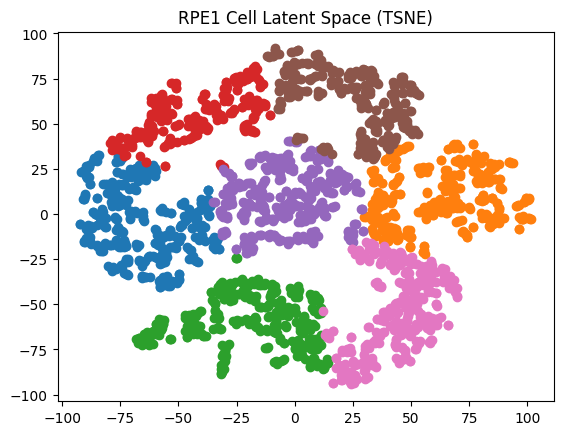

In [71]:
# TSNE Clustering

kmeans = KMeans(n_clusters= 7)
 
# #predict the labels of clusters.
label = kmeans.fit_predict(res)

# np.unique(label,return_counts=True)
df1 = pd.DataFrame(data = res,
                 columns = ["Component 1",
                            "Component 2"])


# plt.title("Latent Dim = 100, K = 6")
plot_clusters(df1,label)

#PyMDE


Dec 09 12:59:42 PM: Computing 11-nearest neighbors, with max_distance=None
Dec 09 12:59:42 PM: Exact nearest neighbors by brute force 
Dec 09 12:59:42 PM: Computing quadratic initialization.


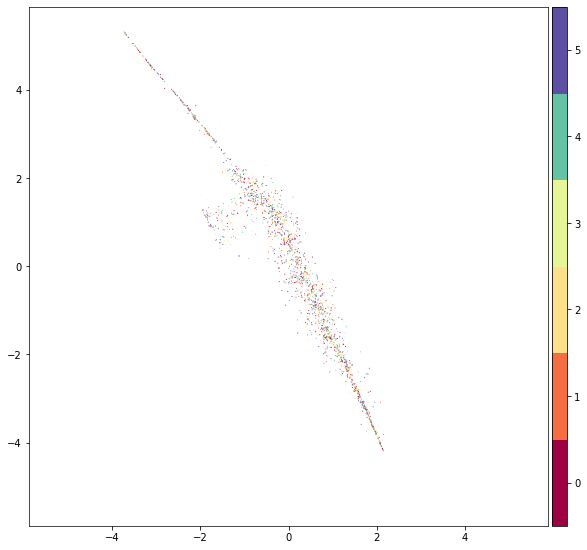

In [ ]:
# !pip install pymde
import pymde
embedding = pymde.preserve_neighbors(mu, embedding_dim=2, verbose=True).embed()
pymde.plot(embedding,color_by=label)

# Elbow

In [56]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 100)
encoded_ = mu.detach().cpu().numpy()
# meam = mu.detach().cpu().numpy()
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(encoded_)
    # kmeanModel.fit(mu)
  
    distortions.append(sum(np.min(cdist(encoded_, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / encoded_.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(encoded_, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / encoded_.shape[0]
    mapping2[k] = kmeanModel.inertia_

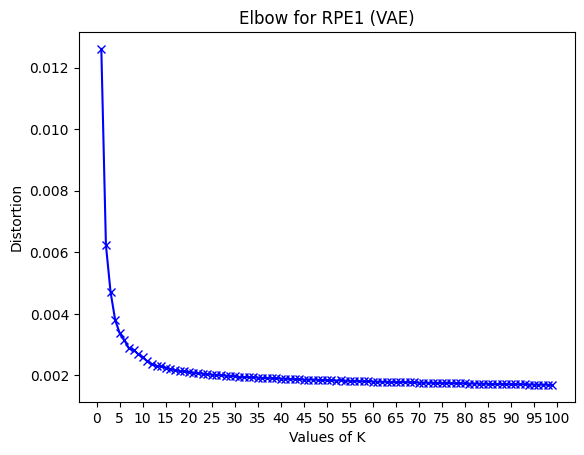

In [61]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.xticks(range(0,101,5))
plt.title('Elbow for RPE1 (VAE)')
plt.show()

# Clusters


In [ ]:
#Initialize the class object
labels = {}
for n_clust in range(2,100):
  kmeans = KMeans(n_clusters= n_clust)
  
  #predict the labels of clusters.
  label = kmeans.fit_predict(mu)
  cluster_ = "Clusters_{}".format(n_clust)
  labels[cluster_] = label
  # np.unique(label,return_counts=True)
  # plot_clusters(df,label)


In [ ]:
Target = "Phenotype"
cluster_directory =  'drive/MyDrive/ACBProj/Cluster/{}'.format(Target)

dictionary = labels
np.save('{}/cluster_labels_rpe1_upto_100.npy'.format(cluster_directory), dictionary) 

# Load
read_dictionary = np.load('{}/cluster_labels_rpe1_upto_100.npy'.format(cluster_directory),allow_pickle='TRUE').item()
print(np.unique(read_dictionary['Clusters_12'])) # displays "world"

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
input_data = pd.read_csv('drive/MyDrive/ACBProj/ProcessedPerturbSeqData/average_RPE1_essential_normalized_singlecell_fold_0.csv')
read_dictionary['Phenotype'] = list(input_data.iloc[:,1:].columns)
# read_dictionary['Genotype'] = list(input_data['gene_id'])

df = pd.DataFrame.from_dict(read_dictionary)
# print(df.columns)
cols = list(df)
cols.insert(0, cols.pop(cols.index('Phenotype')))
df = df.loc[:, cols]
df.to_csv("{}/ClustersUpto100_Phenotype.csv".format(cluster_directory),index=False)